# Universum prescription (Dustbin method)

In [1]:
%matplotlib inline

from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
trainset_imoprt = pickle.load(open("../data/kaggle/train_labeled.p", "rb"))
validset_import = pickle.load(open("../data/kaggle/validation.p", "rb"))
trainset_unlabeled_import = pickle.load(open("../data/kaggle/train_unlabeled.p", "rb"))
trainset_unlabeled_import.train_labels = [10 for i in range(len(trainset_unlabeled_import.train_data))]
full_train_dataset_loader = torch.utils.data.DataLoader(trainset_imoprt, batch_size=64, shuffle=True)
unlabelled_dataset_loader = torch.utils.data.DataLoader(trainset_unlabeled_import, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=64, shuffle=True)

Files already downloaded
3000
750


In [3]:
# Create a dataset with prob' of sampling from unlabelled
def create_partition(prob = 0.01):
    alltrain_data_list = []
    alltrain_labels_list = []
    
    for i, (data, target) in enumerate(full_train_dataset_loader):
        alltrain_data_list.append(data.resize_(data.size()[0],1,28,28))
        alltrain_labels_list.extend(target)

    num_batches = (int)(3000 * prob) / 64
    
    for i, (data, target) in enumerate(unlabelled_dataset_loader):
        if i < num_batches:
            alltrain_data_list.append(data.resize_(data.size()[0],1,28,28))
            alltrain_labels_list.extend(target)

    print("Size of data list", len(alltrain_data_list))
    print("Size of target list", len(alltrain_labels_list))
    return (alltrain_data_list, alltrain_labels_list)


In [4]:


def get_loaders(prob = 0.1):
    alltrain_data_list, alltrain_labels_list = create_partition(prob)
    train_images_tensor = torch.cat(alltrain_data_list, 0)
    train_labels_tensor = torch.LongTensor(alltrain_labels_list)
    train_dataset = torch.utils.data.TensorDataset(train_images_tensor, train_labels_tensor)
    train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    actual_train_dataset_loader = torch.utils.data.DataLoader(trainset_imoprt, batch_size=64, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset_import, batch_size=64, shuffle=True)
    return train_dataset_loader, valid_loader

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 11)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))

        return x



In [6]:
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=1,
                               bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1,
                               bias=False)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1,
                               bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=0, padding=0, ceil_mode=True) # change

        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv1_drop = nn.Dropout2d(0.2)
        self.conv2_drop = nn.Dropout2d(0.3)
        self.conv3_drop = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(32 * 32, 500)
        self.fc2 = nn.Linear(500, 11)

    def forward(self, x):
        x = self.conv1_drop(F.relu(self.maxpool(self.conv1_bn(self.conv1(x)))))

        x = self.conv2_drop(F.relu(self.maxpool(self.conv2_bn(self.conv2(x)))))

        x = self.conv3_drop(F.relu(self.maxpool(self.conv3_bn(self.conv3(x)))))
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

model = NetBN()

In [29]:
# CPU only training
def train(epoch, data_loader,train_errors):
   
    model.train()
    train_loss = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        
        data, target = Variable(data), Variable(target.resize_(len(target)))
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data[0]))
    train_loss /= len(data_loader)
    return train_loss
    

In [30]:
def test(epoch, valid_loader,test_errors):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:
       
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return test_loss
    

Size of data list 62
Size of target list 3960
Training with 0.3 probability of unlabelled samples
Train Epoch: 1 [0/3960 (0%)]	Loss: 2.435198
Train Epoch: 1 [640/3960 (16%)]	Loss: 2.360878
Train Epoch: 1 [1280/3960 (32%)]	Loss: 2.328968
Train Epoch: 1 [1920/3960 (48%)]	Loss: 2.296342
Train Epoch: 1 [2560/3960 (65%)]	Loss: 2.386894
Train Epoch: 1 [3200/3960 (81%)]	Loss: 2.316481
Train Epoch: 1 [3840/3960 (97%)]	Loss: 2.285096

Test set: Average loss: 2.4943, Accuracy: 0/10000 (0%)

Train Epoch: 2 [0/3960 (0%)]	Loss: 2.377066
Train Epoch: 2 [640/3960 (16%)]	Loss: 2.328149
Train Epoch: 2 [1280/3960 (32%)]	Loss: 2.292719
Train Epoch: 2 [1920/3960 (48%)]	Loss: 2.368555
Train Epoch: 2 [2560/3960 (65%)]	Loss: 2.283605
Train Epoch: 2 [3200/3960 (81%)]	Loss: 2.260540
Train Epoch: 2 [3840/3960 (97%)]	Loss: 2.244699

Test set: Average loss: 2.4692, Accuracy: 0/10000 (0%)

Train Epoch: 3 [0/3960 (0%)]	Loss: 2.296206
Train Epoch: 3 [640/3960 (16%)]	Loss: 2.230990
Train Epoch: 3 [1280/3960 (32%)]	Lo

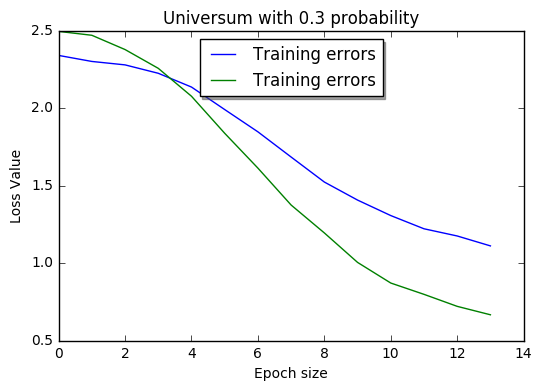

Size of data list 71
Size of target list 4536
Training with 0.5 probability of unlabelled samples
Train Epoch: 1 [0/4536 (0%)]	Loss: 2.443079
Train Epoch: 1 [640/4536 (14%)]	Loss: 2.311895
Train Epoch: 1 [1280/4536 (28%)]	Loss: 2.248409
Train Epoch: 1 [1920/4536 (42%)]	Loss: 2.301363
Train Epoch: 1 [2560/4536 (56%)]	Loss: 1.976566
Train Epoch: 1 [3200/4536 (70%)]	Loss: 2.202016
Train Epoch: 1 [3840/4536 (85%)]	Loss: 2.075963
Train Epoch: 1 [3920/4536 (99%)]	Loss: 2.111645

Test set: Average loss: 2.5548, Accuracy: 0/10000 (0%)

Train Epoch: 2 [0/4536 (0%)]	Loss: 2.281247
Train Epoch: 2 [640/4536 (14%)]	Loss: 2.072486
Train Epoch: 2 [1280/4536 (28%)]	Loss: 2.196877
Train Epoch: 2 [1920/4536 (42%)]	Loss: 2.184125
Train Epoch: 2 [2560/4536 (56%)]	Loss: 2.270947
Train Epoch: 2 [3200/4536 (70%)]	Loss: 2.111464
Train Epoch: 2 [3840/4536 (85%)]	Loss: 2.306184
Train Epoch: 2 [3920/4536 (99%)]	Loss: 2.058058

Test set: Average loss: 2.5153, Accuracy: 0/10000 (0%)

Train Epoch: 3 [0/4536 (0%)]	L

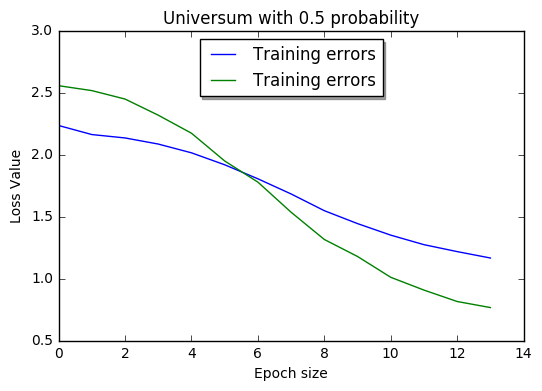

In [32]:
for prob in [0.3, 0.5]:
    (train_dataset_loader, valid_loader) = get_loaders(prob)
    print("Training with {} probability of unlabelled samples".format(prob))
    model = NetBN()#pickle.load(open("model.p", "rb"))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
    train_errors=[]
    test_errors=[]
    for epoch in range(1, 15):
        train_errors.append(train(epoch, train_dataset_loader,train_errors))
        test_errors.append(test(epoch, valid_loader,test_errors))
    print(train_errors)
    plot(train_errors, test_errors, 'Universum with {} probability'.format(prob))

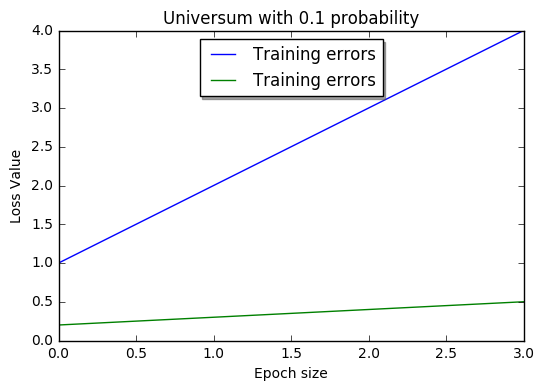

In [28]:
def plot(train_errors, test_errors, title):
    import matplotlib.pyplot as plt
    import numpy as np
    plt.plot(np.arange(len(train_errors)),train_errors,label="Training errors")
    plt.plot(np.arange(len(train_errors)),test_errors,label="Training errors")
    plt.xlabel('Epoch size')
    legend = plt.legend(loc='upper center', shadow=True)
    plt.ylabel('Loss Value')
    plt.title(title)
    plt.savefig(title+'.jpg')
    plt.show()
plot([1,2,3,4], [.2,.3,.4,.5], 'Universum with {} probability'.format(prob))

# Create Sample Submission

In [ ]:
testset = pickle.load(open("../data/kaggle/test.p", "rb"))

In [ ]:
test_loader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=False)

## Test Accuuracy

In [ ]:
test(1, test_loader)

In [ ]:
label_predict = np.array([])
model.eval()
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    temp = output.data.max(1)[1].numpy().reshape(-1)
    label_predict = np.concatenate((label_predict, temp))

In [ ]:
label_predict

In [ ]:
import pandas as pd
predict_label = pd.DataFrame(label_predict, columns=['label'], dtype=int)
predict_label.reset_index(inplace=True)
predict_label.rename(columns={'index': 'ID'}, inplace=True)

In [ ]:
predict_label.head()

In [ ]:
predict_label.to_csv('../data/kaggle/sample_submission.csv', index=False)


In [ ]:
def random_gaussian_noise(npimg):
    h, w = npimg.shape
    mu, sigma = 0, 0.1
    s = np.random.normal(mu, sigma, h * w)
    s = s.reshape((h,w))
    return npimg + s